# Final Project for Research Computing in Earth Science
## *Investigating Ocean Acidification in the Arctic* 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pooch
import matplotlib
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Data Import and Creation of Datasets

## CESM Emission Scenarios

[Index of /data/oceans/ncei/ocads/data/0259391/nc/ESMs/CESM2]('https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0259391/nc/ESMs/CESM2/')

In [2]:
# structure : {base_url}{variables}{scenarios}
cesm = {}
cesm_base_url = 'https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0259391/nc/ESMs/CESM2/CESM2_{}_{}.nc#mode=bytes'
scenarios = ['historical','ssp126','ssp245','ssp370','ssp585']
variables = ['Temperature','Salinity','pHT','pCO2']

for scenario in scenarios:
    cesm_url_list = []
    for variable in variables:
        cesm_url_list.append(cesm_base_url.format(variable,scenario)) 
    
    data = []
    for url in cesm_url_list:
        data.append(xr.open_dataset(url))
        
    cesm[scenario] = xr.merge(data)   

In [ ]:
cesm['historical']

In [ ]:
type(cesm)

In [ ]:
cesm

In [ ]:
type(cesm['ssp126'])

In [ ]:
cesm['ssp126']

### At this stage, have each scenario (historical and all emission forecasts) stored as Xarray dataset and combined into "cesm" dictionary

### To ease later analysis, will: 
- Use pandas to recognize time as dates 
    - Note that this puts years in year-month-day format, even though each variable is representing a whole decade
    - Will keep this mind for conclusions but make the change anyway, because enables easier selection during analysis
- Set latitude and longitude as additional coordinates

In [7]:
for scenario in scenarios:
    cesm[scenario] = cesm[scenario].set_coords(['longitude', 'latitude'])
    cesm[scenario]['time'] = pd.to_datetime(cesm[scenario].time, format='%Y')

In [8]:
cesm['historical']

<xarray.Dataset>
Dimensions:      (time: 18, lat: 180, lon: 360)
Coordinates:
    longitude    (lat, lon) float64 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
    latitude     (lat, lon) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
  * time         (time) datetime64[ns] 1750-01-01 1850-01-01 ... 2010-01-01
Dimensions without coordinates: lat, lon
Data variables:
    temperature  (time, lat, lon) float64 ...
    salinity     (time, lat, lon) float64 ...
    pHT          (time, lat, lon) float64 ...
    pCO2         (time, lat, lon) float64 ...
Attributes:
    title:               Global surface ocean sea surface temperature (ITS90)...
    comment:             This gridded data product contains sea surface tempe...
    reference:           Jiang, L-Q., J. Dunne, B. R. Carter, J. Tjiputra,\n ...
    fair_use_statement:  This data product is made freely available\n        ...
    created_by:          Li-Qing Jiang
    institution:         (a) Cooperative Institute for Satellite Earth System...
    contact:             <Liqing.Jiang@noaa.gov>
    creation_date:       August 14, 2022

In [11]:
cesm['ssp245'].sel(time='2020')

<xarray.Dataset>
Dimensions:      (time: 1, lat: 180, lon: 360)
Coordinates:
    longitude    (lat, lon) float64 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
    latitude     (lat, lon) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
  * time         (time) datetime64[ns] 2020-01-01
Dimensions without coordinates: lat, lon
Data variables:
    temperature  (time, lat, lon) float64 ...
    salinity     (time, lat, lon) float64 ...
    pHT          (time, lat, lon) float64 ...
    pCO2         (time, lat, lon) float64 ...
Attributes:
    title:               Global surface ocean sea surface temperature (ITS90)...
    comment:             This gridded data product contains sea surface tempe...
    reference:           Jiang, L-Q., J. Dunne, B. R. Carter, J. Tjiputra,\n ...
    Fair_use_statement:  This data product is made freely available\n        ...
    created_by:          Li-Qing Jiang
    institution:         (a) Cooperative Institute for Satellite Earth System...
    contact:             <Liqing.Jiang@noaa.gov>
    creation_date:       August 14, 2022

## Sea Ice Extent

[Sea Ice Concentration, NOAA/NSIDC Climate Data Record V3, Arctic, 25km, Science Quality, 1978-2019, Monthly DEPRECATED]('https://polarwatch.noaa.gov/erddap/files/nsidcCDRiceSQnhmday/')

Will determine sea ice extent by sea ice concentration, defined where sea ice concentration is less than 15% in September of each year (as done in Krasting et al. 2022)

In [31]:
from erddapy import ERDDAP
import json
e = ERDDAP(
    server='https://polarwatch.noaa.gov/erddap',
    protocol='griddap')

### First get latitude and longitude grid for the Arctic (Northern Hemisphere)

In [37]:
e.dataset_id = 'nsidcCDRice_nh_grid' # https://polarwatch.noaa.gov/erddap/griddap/nsidcCDRice_nh_grid.html
e.griddap_initialize()
print(f'variables in this dataset:\n\n{e.variables}')
print(f'\nconstraints for this dataset:\n\n{json.dumps(e.constraints, indent=1)}')
ds_latlon = e.to_xarray()
ds_latlon.load()

variables in this dataset:

['longitude', 'latitude']

constraints for this dataset:

{
 "ygrid>=": 5837500.0,
 "ygrid<=": -5337500.0,
 "ygrid_step": 1,
 "xgrid>=": -3837500.0,
 "xgrid<=": 3737500.0,
 "xgrid_step": 1
}


<xarray.Dataset>
Dimensions:    (ygrid: 448, xgrid: 304)
Coordinates:
  * ygrid      (ygrid) float32 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * xgrid      (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
Data variables:
    longitude  (ygrid, xgrid) float64 168.3 168.1 168.0 ... -10.36 -10.18 -9.999
    latitude   (ygrid, xgrid) float64 31.1 31.2 31.3 31.39 ... 34.68 34.58 34.47
Attributes: (12/62)
    acknowledgement:                             This project was supported i...
    cdm_data_type:                               Grid
    contributor_name:                            Walt Meier, Ruth Duerr, Flor...
    contributor_role:                            PrincipalInvestigator,author...
    Conventions:                                 CF-1.6, COARDS, ACDD-1.3
    creator_email:                               nsidc@nsidc.org
    ...                                          ...
    source:                                       Satellite observations
    sourceUrl:                                   ftp://sidads.colorado.edu/pu...
    spatial_resolution:                          25km
    standard_name_vocabulary:                    CF Standard Name Table v29
    summary:                                     This ERDDAP data set provide...
    title:                                       Sea Ice Concentration Lat-Lo...

### Then get sea ice concentration on a monthly basis from 1978 to 2022

In [39]:
e.dataset_id = 'nsidcG02202v4nhmday' # https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.html
e.griddap_initialize()
print(f'variables in this dataset:\n\n{e.variables}')
print(f'\nconstraints for this dataset:\n\n{json.dumps(e.constraints, indent=1)}')
e.variables = ['cdr_seaice_conc_monthly'] #  consider if need any other variables from list printed by line above
e.constraints = None
ds = e.to_xarray()
ds

variables in this dataset:

['cdr_seaice_conc_monthly', 'melt_onset_day_cdr_seaice_conc_monthly', 'nsidc_bt_seaice_conc_monthly', 'nsidc_nt_seaice_conc_monthly', 'qa_of_cdr_seaice_conc_monthly', 'stdev_of_cdr_seaice_conc_monthly']

constraints for this dataset:

{
 "time>=": "2022-05-01T00:00:00Z",
 "time<=": "2022-05-01T00:00:00Z",
 "time_step": 1,
 "ygrid>=": 5837500.0,
 "ygrid<=": -5337500.0,
 "ygrid_step": 1,
 "xgrid>=": -3837500.0,
 "xgrid<=": 3737500.0,
 "xgrid_step": 1
}


<xarray.Dataset>
Dimensions:                  (time: 523, ygrid: 448, xgrid: 304)
Coordinates:
  * time                     (time) datetime64[ns] 1978-11-01 ... 2022-05-01
  * ygrid                    (ygrid) float32 5.838e+06 5.812e+06 ... -5.338e+06
  * xgrid                    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
Attributes: (12/65)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    comment:                                             none
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2022-05-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 1978-11-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

In [44]:
ds_ice = xr.merge([ds, ds_latlon])
ds_ice

<xarray.Dataset>
Dimensions:                  (time: 523, ygrid: 448, xgrid: 304)
Coordinates:
  * time                     (time) datetime64[ns] 1978-11-01 ... 2022-05-01
  * ygrid                    (ygrid) float32 5.838e+06 5.812e+06 ... -5.338e+06
  * xgrid                    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
    longitude                (ygrid, xgrid) float64 168.3 168.1 ... -9.999
    latitude                 (ygrid, xgrid) float64 31.1 31.2 ... 34.58 34.47
Attributes: (12/65)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    comment:                                             none
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2022-05-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 1978-11-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

### To ease later analysis:
- Set coordinates as latitude and longitude
- (Note that time is already correctly identified as dates)

In [48]:
ds_ice = ds_ice.set_coords(['latitude', 'longitude'])
ds_ice

<xarray.Dataset>
Dimensions:                  (time: 523, ygrid: 448, xgrid: 304)
Coordinates:
  * time                     (time) datetime64[ns] 1978-11-01 ... 2022-05-01
  * ygrid                    (ygrid) float32 5.838e+06 5.812e+06 ... -5.338e+06
  * xgrid                    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
    longitude                (ygrid, xgrid) float64 168.3 168.1 ... -9.999
    latitude                 (ygrid, xgrid) float64 31.1 31.2 ... 34.58 34.47
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
Attributes: (12/65)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    comment:                                             none
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2022-05-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 1978-11-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

# Characterization Figures

### Create Plots to Examine CESM Data

### Create Plots to Examine Sea Ice Data

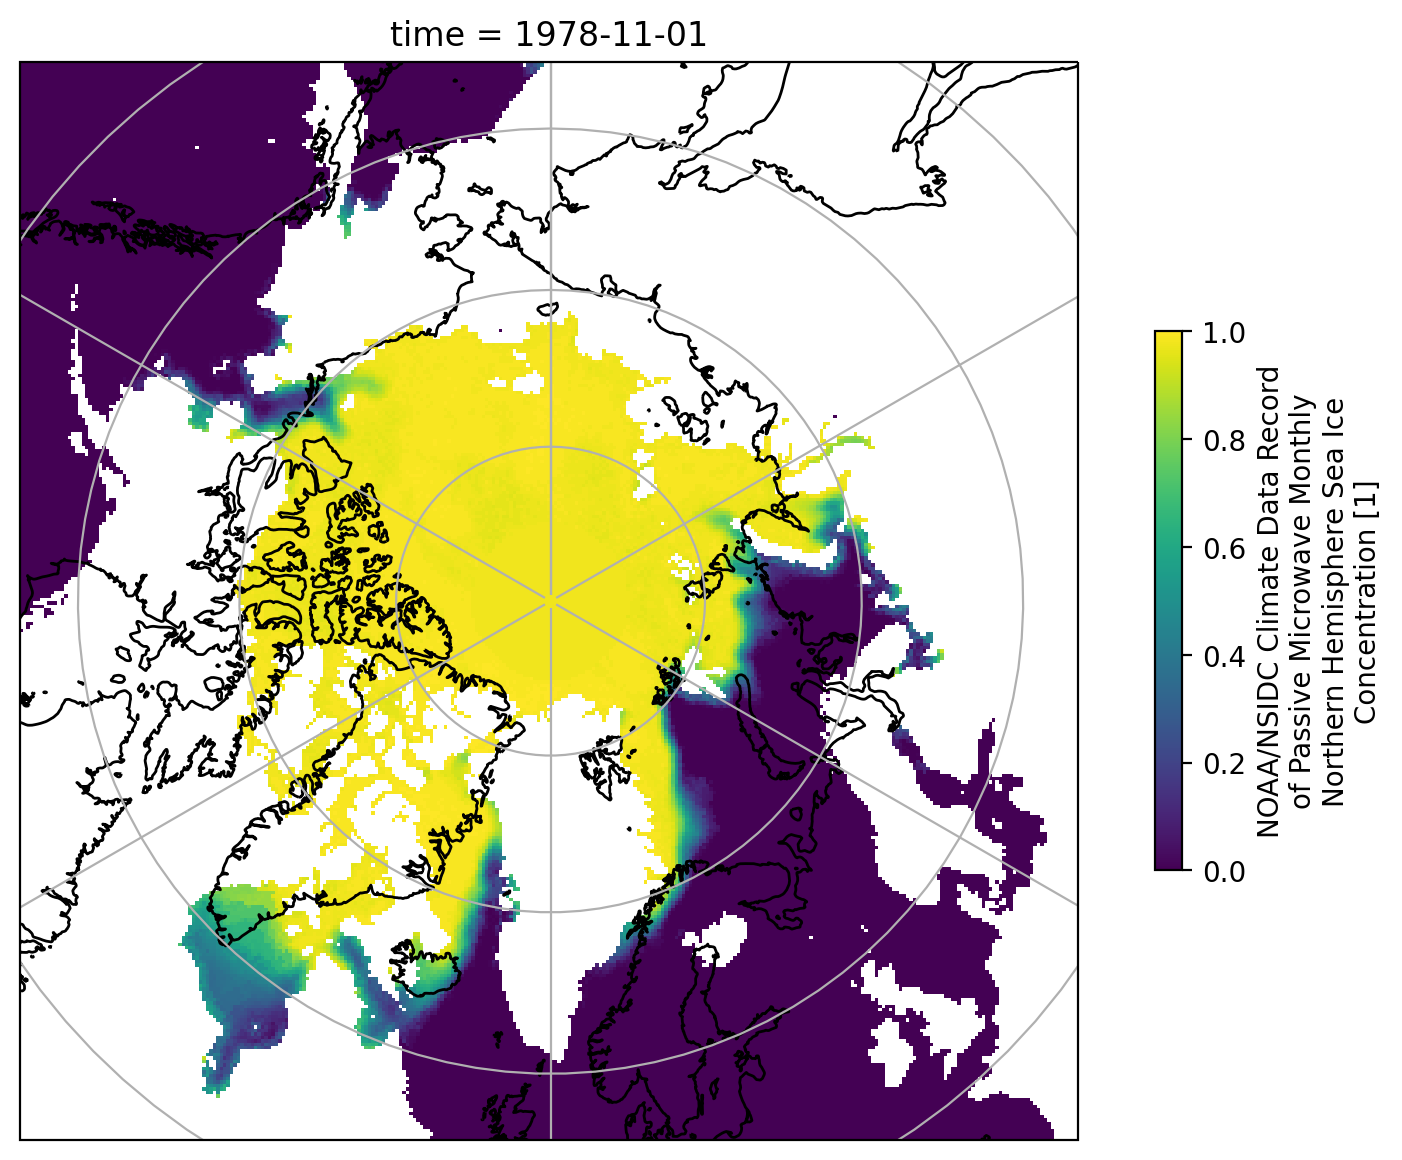

In [50]:
fig = plt.figure(figsize=(10,7))
proj_ant = ccrs.NorthPolarStereo()
ax = plt.axes(projection=proj_ant)
ax.set_extent([-180, 180, 100, 56], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

ice_conc = ds_ice.cdr_seaice_conc_monthly[0]
ice_conc = ice_conc.where(ice_conc<=1)
ice_conc.plot(vmin=0, vmax=1, cbar_kwargs={'shrink': 0.5})

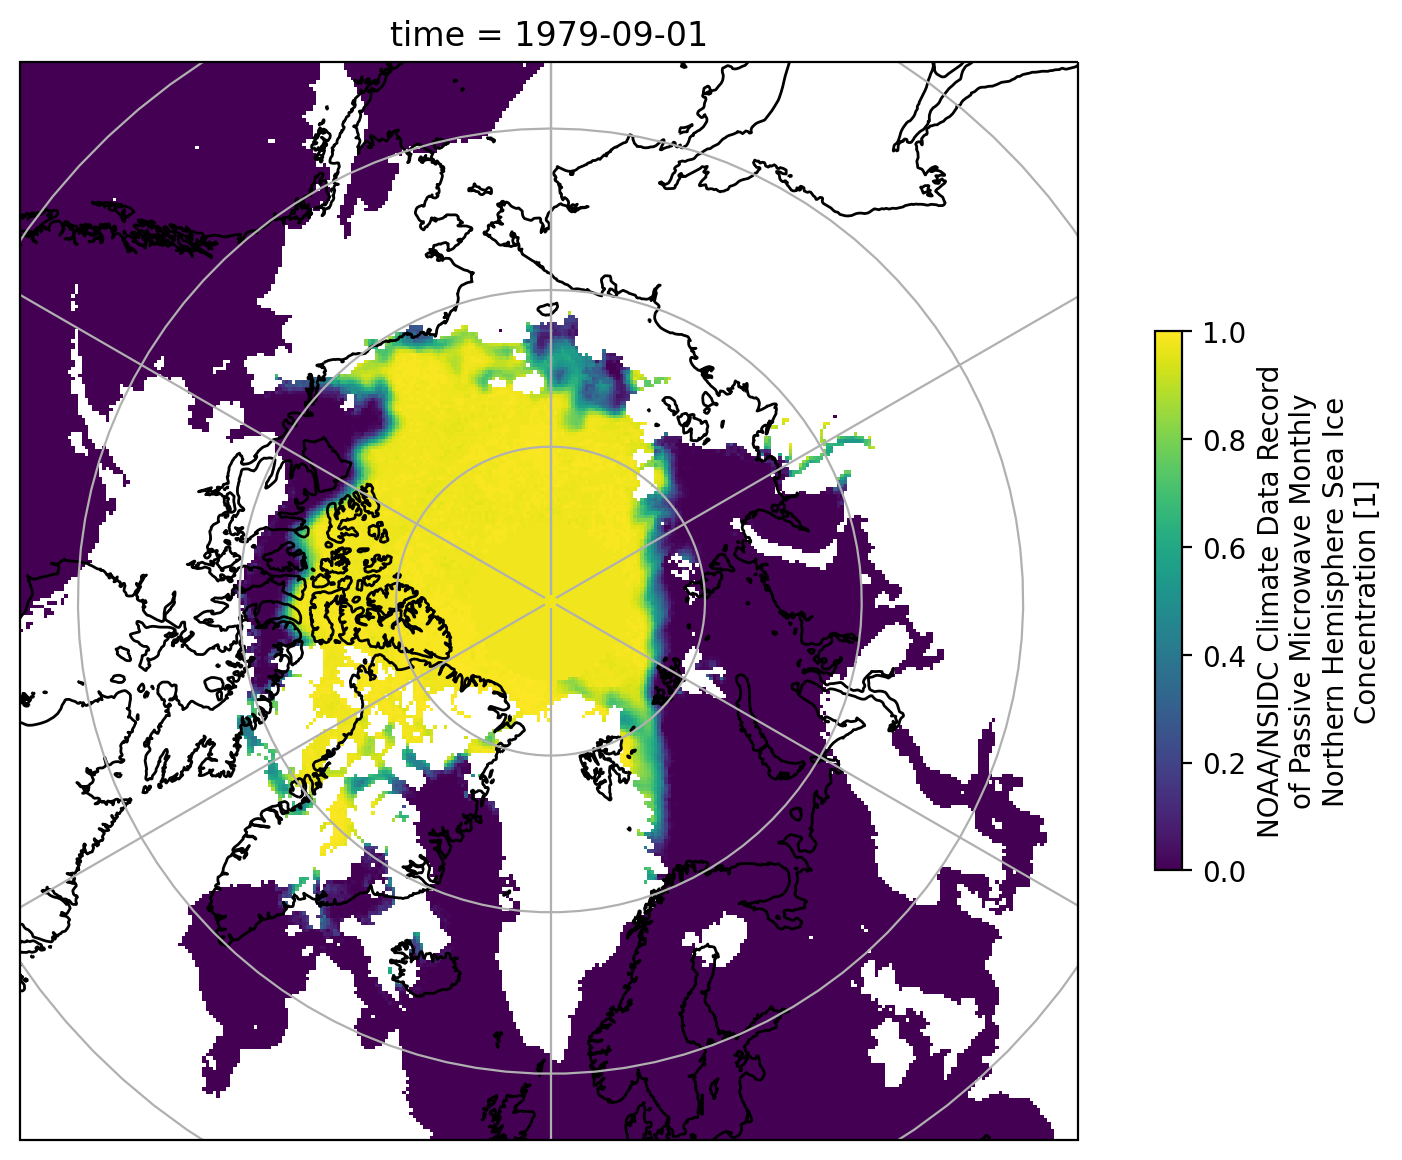

In [53]:
fig = plt.figure(figsize=(10,7))
proj_ant = ccrs.NorthPolarStereo()
ax = plt.axes(projection=proj_ant)
ax.set_extent([-180, 180, 100, 56], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

ice_conc = ds_ice.cdr_seaice_conc_monthly[10] # did 10 to look at September, also try ds_ice.cdr_seaice_conc[ds_ice.cdr_seaice_conc.time=='2021-09-01']
ice_conc = ice_conc.where(ice_conc<=1)
ice_conc.plot(vmin=0, vmax=1, cbar_kwargs={'shrink': 0.5})

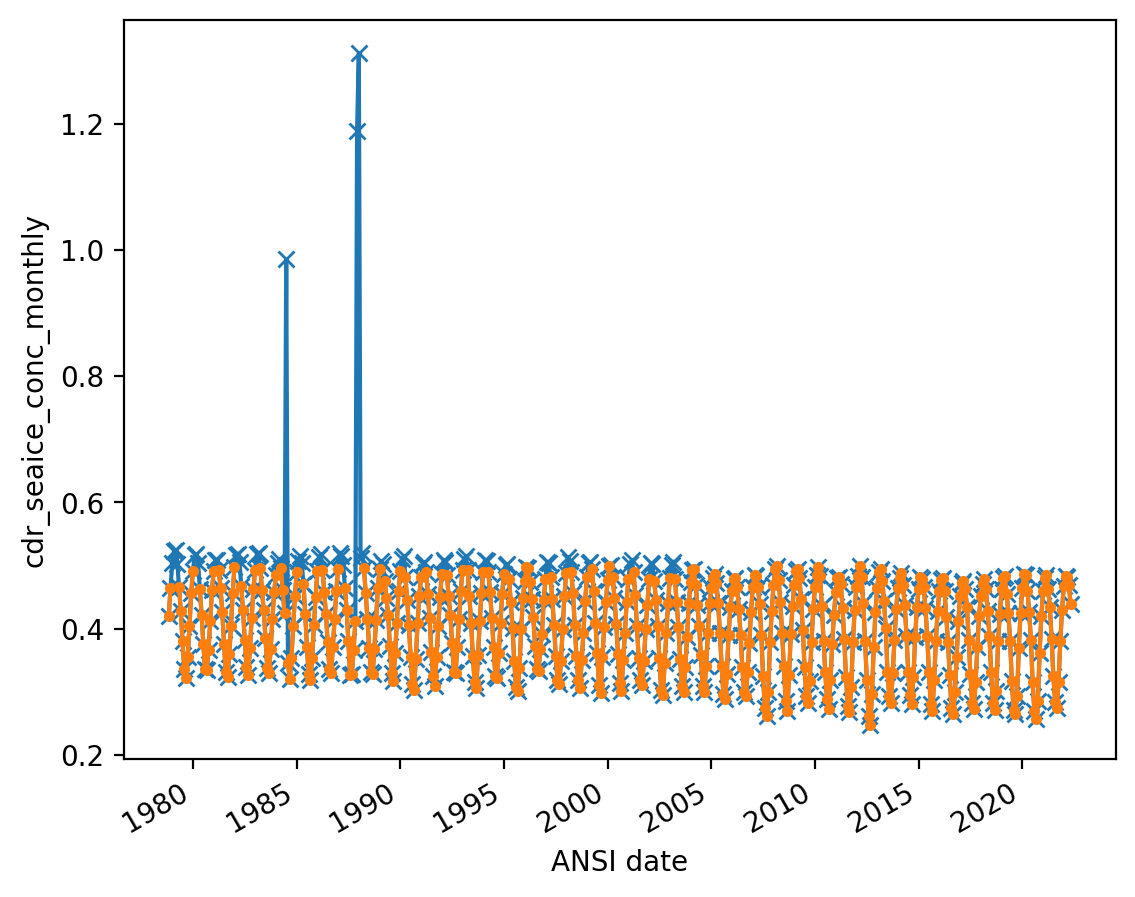

In [54]:
ice_monthly = ds.cdr_seaice_conc_monthly.mean(dim=('ygrid', 'xgrid'))
ds.cdr_seaice_conc_monthly.mean(dim=('ygrid', 'xgrid')).plot(marker='x');
ice_monthly.where(ice_monthly<0.5).plot(marker='.');

# Analysis and Resulting Figures

## Calculate sea ice concentration anomaly

In [ ]:
#import datetime
#ice_conc = ds_ice.cdr_seaice_conc.datetime['time'=='2021-08-01']

In [60]:
#print(ice_conc)

In [59]:
#df = pd.DataFrame(ice_conc, columns=['time', 'ygrid','xgrid','cdr_seaice_conc'])
#df = df.set_index('ISO_TIME')

In [58]:
#ice_conc.groupby(ice_conc.index.dayofyear).aggregate({'mean',
#                                                    'std'}).plot(marker='.',xlim=(0,365),title='Climatology of Datapoint Counts',xlabel='Day of Year', ylabel='Datapoint Counts')

In [57]:
#def standardize(x):
#    return (x - x.mean())

#fig, ax = plt.subplots(figsize=(10,6))
#anomaly = daily14.groupby(daily14.index.dayofyear).transform(standardize);
#anomaly.resample('A').mean().plot(marker='.');
#ax.set_title('Anomaly of Daily Counts at Annual Resolution'); #will need to change, don't just want datapoint COUNTS, want actual anomaly
#ax.set_xlabel('Year');
#ax.set_ylabel('Anomaly');

# Conclusions